<a href="https://colab.research.google.com/github/qingchuan-s/Thesis/blob/main/multisimulation_week7_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install panda
!pip install numpy
!pip install pylab
!pip install sciris
!pip install covasim
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import pylab as pl
import sciris as sc
import covasim as cv
import optuna as op
import os

In [ ]:
from google.colab import files
upload = files.upload()

Saving Denmark_data.csv to Denmark_data.csv


In [ ]:
import pandas as pd
import io

df = pd.read_csv(io.StringIO(upload['Denmark_data.csv'].decode('utf-8')),sep=',')
df = df[0:310]

In [ ]:
# Define the vaccine subtargeting
def prior_test(sim):
    old_or_sick  = cv.true((sim.people.age > 60) + (sim.people.symptomatic == True)) 
    others  = cv.true((sim.people.age <= 60) * (sim.people.symptomatic == False))
    inds = sim.people.uid # Everyone in the population -- equivalent to np.arange(len(sim.people))
    vals = np.ones(len(sim.people)) # Create the array
    vals[old_or_sick] = 1.5 
    vals[others] = 0.5
    output = dict(inds=inds, vals=vals)
    return output

In [ ]:
def create_sim(seed):

    beta = 0.014 #0.011
    pop_infected =20 # initial cases of infection
   
    start_day = '2020-02-01'
    end_day   = '2020-12-31'
    data_file = df
    # Set the parameters
    total_pop    = 5.8e6 # Denmark population size
    pop_size     = 100e3 # Actual simulated population
    pop_scale    = int(total_pop/pop_size)
    pop_type     = 'hybrid'
    asymp_factor = 2
    pars = sc.objdict(
        pop_size     = pop_size,
        pop_infected = pop_infected,
        pop_scale    = pop_scale,
        pop_type     = pop_type,
        start_day    = start_day,
        end_day      = end_day,
        beta         = beta,
        asymp_factor = asymp_factor,
        rescale      = True,
        verbose      = 0.1,
        rand_seed   = seed,
    )
    # Create the baseline simulation
    sim = cv.Sim(pars=pars, datafile=data_file, location='denmark')
    
    # Day 1: 2020-02-01
    # Day 118: 2020-06-17
    # Day 244: 2020-10-01
    relative_death = cv.dynamic_pars(rel_death_prob=dict(days=[1,118,229,277], vals=[1.212,0.350,0.10,0.9]))
    
    interventions = [relative_death]
    
    ### Change beta ###
    beta_days = ['2020-03-15','2020-04-15','2020-05-10','2020-06-22','2020-07-20','2020-08-22','2020-09-01','2020-09-22','2020-10-01','2020-10-15','2020-11-01',
                 '2020-11-20','2020-12-07','2020-12-20']
    h_beta_changes = [1.10, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.10, 1.00, 1.20, 1.20, 1.20]
    s_beta_changes = [0.80, 0.50, 0.50, 0.40, 0.60, 0.60, 1.00, 1.00, 0.60, 1.00, 0.80, 1.10, 0.90, 0.50]
    w_beta_changes = [0.80, 0.50, 0.50, 0.40, 0.60, 0.60, 1.00, 1.00, 0.60, 1.00, 0.90, 1.10, 0.90, 0.50]
    c_beta_changes = [0.90, 0.60, 0.50, 0.70, 0.90, 0.80, 1.00, 0.95, 0.60, 1.00, 0.90, 1.10, 1.10, 0.60]
    
    # Define the beta changes
    h_beta = cv.change_beta(days=beta_days, changes=h_beta_changes, layers='h')
    s_beta = cv.change_beta(days=beta_days, changes=s_beta_changes, layers='s')
    w_beta = cv.change_beta(days=beta_days, changes=w_beta_changes, layers='w')
    c_beta = cv.change_beta(days=beta_days, changes=c_beta_changes, layers='c')

    clip_days = ['2020-03-15','2020-04-15','2020-05-10','2020-06-08','2020-06-22','2020-08-17','2020-09-01','2020-09-15','2020-10-05',
                 '2020-11-05','2020-11-20','2020-12-07','2020-12-19','2020-12-25']
    s_clip_changes = [0.01, 0.20, 0.40, 0.65, 0.05, 0.10, 0.90, 0.80, 0.70, 0.80, 0.80, 0.60, 0.15, 0.05]
    w_clip_changes = [0.10, 0.30, 0.50, 0.70, 0.60, 0.80, 1.00, 0.70, 0.70, 0.70, 0.70, 0.70, 0.70, 0.10]
    c_clip_changes = [0.20, 0.40, 0.60, 0.89, 1.00, 1.00, 1.00, 0.90, 0.80, 0.90, 0.90, 0.90, 1.00, 0.30]
    
    # Define the beta changes)
    s_clip = cv.clip_edges(days=clip_days, changes=s_clip_changes, layers='s')
    w_clip = cv.clip_edges(days=clip_days, changes=w_clip_changes, layers='w')
    c_clip = cv.clip_edges(days=clip_days, changes=c_clip_changes, layers='c')
    
    interventions += [h_beta, w_beta, s_beta, c_beta, w_clip, s_clip, c_clip]
    
    # import infections from 2020-02-20 to 2020-03-01
    imports1 = cv.dynamic_pars(n_imports=dict(days=[25, 35], vals=[2,0]))
    imports2 = cv.dynamic_pars(n_imports=dict(days=[171, 190], vals=[2,0]))
    interventions += [imports1,imports2]
 
    iso_vals   = [{'h': 0.5, 's': 0.05, 'w': 0.05, 'c': 0.1}] #dict(h=0.5, s=0.05, w=0.05, c=0.1)
    interventions += [cv.dynamic_pars({'iso_factor': {'days': sim.day('2020-03-15'), 'vals': iso_vals }})]
    
    # From May 12, starting tracing and isolation strategy
    tti_day =  sim.day('2020-05-12')
    tracing_prob = dict(h=1.0, s=0.5, w=0.5, c=0.2)
    trace_time   = {'h':0, 's':1, 'w':1, 'c':2}   
    interventions += [cv.contact_tracing(trace_probs=tracing_prob, trace_time=trace_time, start_day='2020-05-12')]
     
    interventions += [cv.test_num(daily_tests=sim.data['new_tests'], start_day=0, end_day=sim.day(end_day), test_delay=1, symp_test=50,
                    sensitivity=0.97,subtarget=prior_test), ]
    
    
    sim.update_pars(interventions=interventions)
    
    for intervention in sim['interventions']:
        intervention.do_plot = False
    return sim

Initializing sim with 100000 people for 334 days
Loading location-specific data for "denmark"
Initializing sim with 100000 people for 334 days
Loading location-specific data for "denmark"
Note: contact tracing (index 11) is scheduled before testing (12); this creates a 1-day delay. Unless this is intentional, please reorder the interentions.
  Running "Sim 0": 2020-02-01 ( 0/334) (8.25 s)  ———————————————————— 0%
Note: contact tracing (index 11) is scheduled before testing (12); this creates a 1-day delay. Unless this is intentional, please reorder the interentions.
  Running "Sim 2": 2020-02-01 ( 0/334) (8.23 s)  ———————————————————— 0%
  Running "Sim 0": 2020-02-11 (10/334) (8.85 s)  ———————————————————— 3%
  Running "Sim 2": 2020-02-11 (10/334) (8.82 s)  ———————————————————— 3%
  Running "Sim 0": 2020-02-21 (20/334) (9.46 s)  •——————————————————— 6%
  Running "Sim 2": 2020-02-21 (20/334) (9.42 s)  •——————————————————— 6%
  Running "Sim 0": 2020-03-02 (30/334) (10.08 s)  •———————————

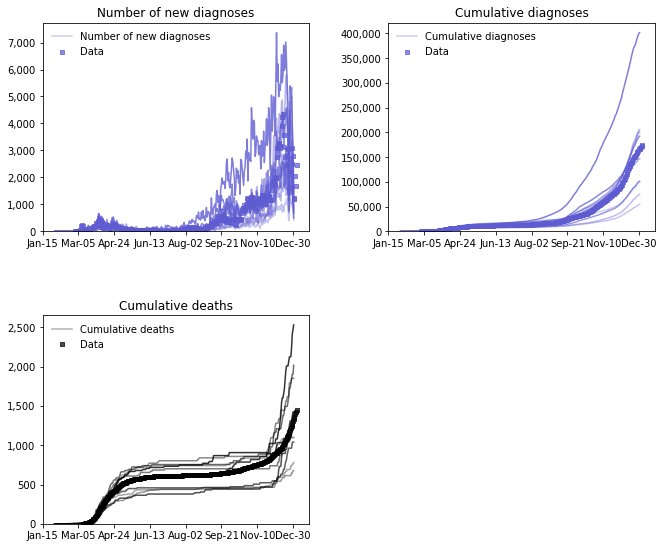

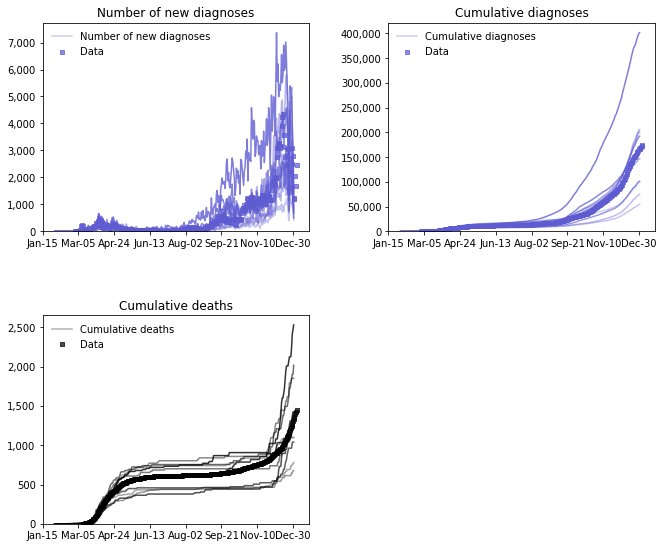

In [ ]:
s0 = create_sim(seed=1)
sims = []
for seed in range(10):
  sim = s0.copy()
  sim['rand_seed'] = seed
  sim.set_seed()
  sim.label = f"Sim {seed}"
  sims.append(sim)
msim = cv.MultiSim(sims)

msim.run()
msim.plot(to_plot=[  'new_diagnoses', 'cum_diagnoses', 'cum_deaths'], do_save=True, do_show=False, fig_path=f'denmark.png',
    legend_args={'loc': 'upper left'}, axis_args={'hspace': 0.4}, interval=50, n_cols=2)


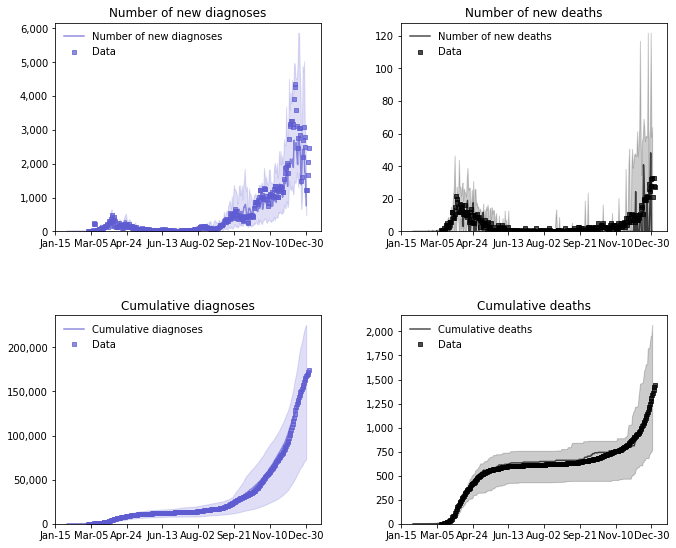

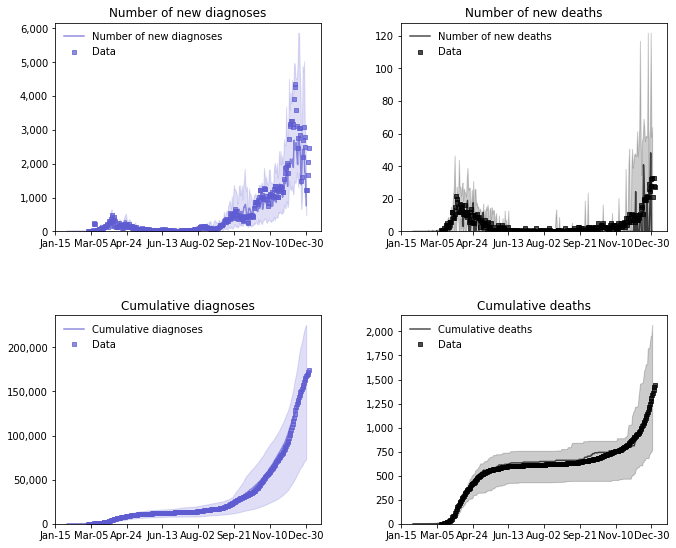

In [ ]:
msim.reduce()
        #'new_deaths',
msim.plot(to_plot=['new_diagnoses', 'new_deaths','cum_diagnoses', 'cum_deaths'], do_save=True, do_show=False, fig_path=f'denmark.png',
    legend_args={'loc': 'upper left'}, axis_args={'hspace': 0.4}, interval=50, n_cols=2)

In [ ]:
for sim in msim.sims:
  fit = sim.compute_fit()
  print(fit.mismatches)
  print(fit.mismatch)

#0. cum_tests:     0.002932840705776483
#1. cum_diagnoses: 416.5044705086236
#2. cum_severe:    214.39536197761979
#3. cum_deaths:    384.2165759866242
1015.1193413135734
#0. cum_tests:     0.002104608772122522
#1. cum_diagnoses: 52.82733635804148
#2. cum_severe:    86.43531268744125
#3. cum_deaths:    79.7655914506007
219.03034510485554
#0. cum_tests:     0.0011285126670517857
#1. cum_diagnoses: 50.811638620552344
#2. cum_severe:    47.51752452789308
#3. cum_deaths:    445.93495666819695
544.2652483293094
#0. cum_tests:     0.0009253968665035753
#1. cum_diagnoses: 105.05712488964679
#2. cum_severe:    9.376571038310006
#3. cum_deaths:    359.04982227021355
473.48444359503685
#0. cum_tests:     0.0013059376097061294
#1. cum_diagnoses: 59.02201459829655
#2. cum_severe:    113.17360200296858
#3. cum_deaths:    324.15370467219117
496.350627211066
#0. cum_tests:     0.0017271783126271863
#1. cum_diagnoses: 48.740096976214545
#2. cum_severe:    114.63779222569724
#3. cum_deaths:    144.7805

Initializing sim with 100000 people for 334 days
Loading location-specific data for "denmark"
Initializing sim with 100000 people for 334 days
Loading location-specific data for "denmark"
Note: contact tracing (index 11) is scheduled before testing (12); this creates a 1-day delay. Unless this is intentional, please reorder the interentions.
Note: contact tracing (index 11) is scheduled before testing (12); this creates a 1-day delay. Unless this is intentional, please reorder the interentions.
  Running "Sim 1": 2020-02-01 ( 0/334) (7.77 s)  ———————————————————— 0%
  Running "Sim 5": 2020-02-01 ( 0/334) (7.73 s)  ———————————————————— 0%
  Running "Sim 5": 2020-02-11 (10/334) (8.34 s)  ———————————————————— 3%
  Running "Sim 1": 2020-02-11 (10/334) (8.39 s)  ———————————————————— 3%
  Running "Sim 5": 2020-02-21 (20/334) (8.95 s)  •——————————————————— 6%
  Running "Sim 1": 2020-02-21 (20/334) (9.04 s)  •——————————————————— 6%
  Running "Sim 5": 2020-03-02 (30/334) (9.59 s)  •————————————

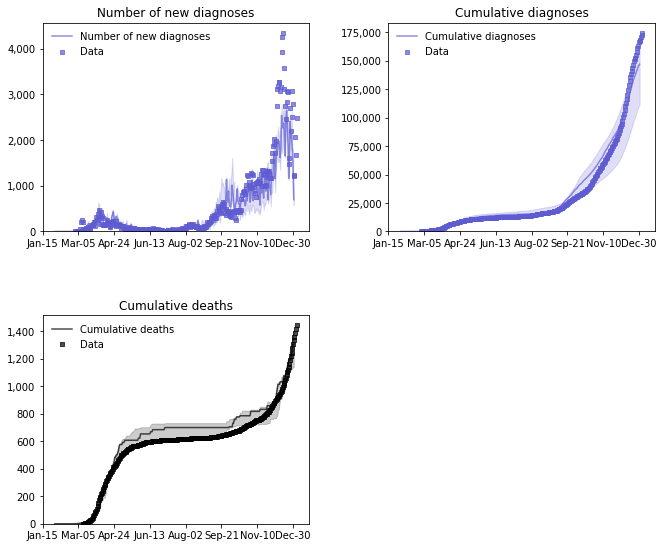

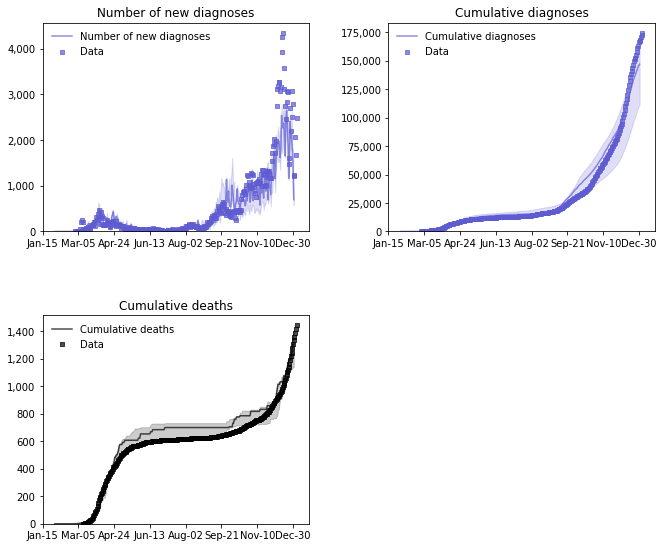

In [ ]:
s0 = create_sim(seed=1)
sims = []
for seed in [1,5,9]:
  sim = s0.copy()
  sim['rand_seed'] = seed
  sim.set_seed()
  sim.label = f"Sim {seed}"
  sims.append(sim)
msim = cv.MultiSim(sims)

msim.run()
msim.reduce()
msim.plot(to_plot=[  'new_diagnoses', 'cum_diagnoses', 'cum_deaths'], do_save=True, do_show=False, fig_path=f'denmark.png',
    legend_args={'loc': 'upper left'}, axis_args={'hspace': 0.4}, interval=50, n_cols=2)


In [ ]:
resfolder = 'results'

if __name__ == '__main__':

    x = sc.objdict(
        beta = 0.01,
        rel_death_prob1 = 0.8,) 
        #rel_death_prob2 = 0.5,
        #rel_death_prob3 = 0.6,)
    
    betas = [i / 10000 for i in range(90, 170, 2)]
    rel_death_prob1s = [i / 100 for i in range(50, 120, 2)]
    #rel_death_prob2s = [i / 100 for i in range(50, 120, 2)]
    #rel_death_prob3s = [i / 100 for i in range(50, 120, 2)]
    
    fitsummary = {}
    for beta in betas:
        fitsummary[beta] = []
        for rel_death_prob1 in rel_death_prob1s:
           x = sc.objdict(beta=beta,rel_death_prob1=rel_death_prob1)
           sc.blank()
           print('---------------\n')
           print(f'Beta: {beta}, rel_death_prob1: {rel_death_prob1}...')
           print('---------------\n')
           seed =1
           s0 = create_sim(x,seed)
           sims = []
           for seed in range(10):
             sim = s0.copy()
             sim['rand_seed'] = seed
             sim.set_seed()
             sim.label = f"Sim {seed}"
             sims.append(sim)
           msim = cv.MultiSim(sims)
           msim.run()
           fitsummary[beta].append([sim.compute_fit().mismatch for sim in msim.sims])
    
    sc.saveobj(f'{resfolder}/fitsummary.obj',fitsummary)